In [1]:
DATASET = "COVID19_2023_02_22.csv"

REBUILD_DATASET = False

In [2]:
if REBUILD_DATASET:

    import csv
    from tqdm import tqdm

    # Print columns names
    with open(DATA_SOURCE, 'r', encoding="utf-8") as csv_src:
        header = next(csv_src).split(sep=',')
        for n, col in enumerate(header):
            print(n, ":", col)

    DATA_SOURCE = "tweets_processed_merged_users_2023_02_22.csv"

    # Set this to limit the target number of CSV rows to process.
    # Set to None to process all rows
    ROWS_LIMIT = None #500_000 #300_000
    

    # Initialize statistics
    MONITOR = {"processed_tweets_count": 0,
               "fixed_tweets_count": 0,
               "broken_tweets": [],
               "fixed_tweets": []}
    
    # Open two file streams at the same time: source and destination
    with (open(DATA_SOURCE, 'r', encoding="utf-8") as csv_src, open(DATASET, 'w', encoding="utf-8") as csv_dst):
              
        csv_reader = csv.reader(csv_src, delimiter=',', lineterminator='\n')
        csv_writer = csv.writer(csv_dst, delimiter=',', lineterminator='\n')
    
        row_buffer = []
        
        for n, row in tqdm(enumerate(csv_reader)):
    
            if n == 0:
                # Determine number of columns
                ncols = len(row)
            
                # Write the header in the dest file
                csv_writer.writerow(row)       
        
            elif not ROWS_LIMIT or n <= ROWS_LIMIT:
    
                # Counter for stats
                MONITOR["processed_tweets_count"] += 1
                
                # Check if values mismatch
                if len(row) != ncols:

                    MONITOR["broken_tweets"].append(','.join(row))
        
                    # Fix broken row point
                    prev_last_token = "" if len(row_buffer) == 0 else row_buffer.pop() 
                    next_first_token = "" if len(row) == 0 else row.pop(0)
                    fixed_token = prev_last_token + next_first_token
                    row_buffer.append(fixed_token)
                    row_buffer += row
        
                    # Check if the row is completely fixed
                    if len(row_buffer) == ncols:
                        
                        MONITOR["fixed_tweets_count"] += 1
                        MONITOR["fixed_tweets"].append(','.join(row_buffer))
                        
                        row = row_buffer
                        row_buffer = [] # Reset the row buffer for next broken rows
                        
                    else:
                        
                        continue # Skip current iteration
        
                # Write the row in the destination file
                row = [token.replace('\n', "<return>") for token in row]
                csv_writer.writerow(row)
        
            else:
                
                break # When ROWS_LIMIT is not None this will stop the reading loop

    print(f"Processed {MONITOR['processed_tweets_count']} tweets, fixed: {MONITOR['fixed_tweets_count']}")

In [3]:
import re

def extract_domains(input_string):
    pattern = r"(?:(?:https?://www\.)|(?:https?://)|(?:www\.))([\w.-]+\.\w{2,})(?:(?:/)|(?: )|(?:;))?"
    matches = re.findall(pattern, input_string)
    return matches

# Example usage:
input_string = "Check out https://www.example.com; and http://another-example.org for more info."
result = extract_domains(input_string)
print(result)


['example.com', 'another-example.org']


In [4]:
import re

def extract_urls(input_string):
    pattern = r"(https?://(?:www\.)?[\w.-]+\.\w{2,}(?:[^\s]*)?)"
    matches = re.findall(pattern, input_string)
    return matches

# Example usage:
input_string = "Check out https://www.exampl;e.com/path1; and http://another-example.org/path2 for more info."
result = extract_urls(input_string)
print(result)


['https://www.exampl;e.com/path1;', 'http://another-example.org/path2']


In [5]:
import pandas as pd

# use_cols = ["tweet_id", "created_at", "user_id", "is_original", "is_retweet", "is_reply", "is_quote", "urls"]
use_cols = ["tweet_id", "user_id", "urls"]

df_a = pd.read_csv("COVID19_2023_02_22.csv", nrows=100, usecols=use_cols)
extract_domains(df_a["urls"].dropna().iloc[16])

['repubblica.it', 'tweetedtimes.com']

In [6]:
newsguard_cols = ["identifier", "identifierAlt", "score"]
df_b = pd.read_csv("newsguard_ratings.csv", usecols=newsguard_cols)

In [7]:
import numpy as np
import dask.dataframe as dd

# Specify columns to read
use_cols = ["tweet_id",
            "created_at",
            "user_id",
            "is_retweet",
            "is_reply",
            "is_quote",
            "retweeted_status_id",
            "in_reply_to_status_id",
            "quoted_status_id"]

dtypes = {"tweet_id": str,
          "created_at": object,
          "user_id": str,
          "is_retweet": int,
          "is_reply": int,
          "is_quote": int,
          "retweeted_status_id": str,
          "in_reply_to_status_id":str,
          "quoted_status_id": str}

# Read the data
ddf = dd.read_csv("COVID19_2023_02_22.csv", usecols=use_cols, dtype=dtypes)

# Parse date time
ddf["created_at"] = dd.to_datetime(ddf["created_at"])

# Squash origin id column
ddf["origin_id"] = ddf["retweeted_status_id"].combine_first(ddf["in_reply_to_status_id"]).combine_first(ddf["quoted_status_id"])
ddf["origin_id"] = ddf["origin_id"].fillna("ORIGIN")

# Drop
ddf = ddf.drop(columns=["retweeted_status_id", "in_reply_to_status_id", "quoted_status_id"])

In [8]:
#ddf.compute()

In [9]:
#ddf.head(10)

In [10]:
#single_tweet = ddf[ddf["origin_id"] == "1414650859452080128"]
#tweet_df = single_tweet.compute()

In [11]:
#tweet_df

In [12]:
#resampled_df = tweet_df[["created_at", "is_retweet"]].resample("1h", on="created_at", label="right").sum()
#resampled_df.rename(columns={"is_retweet": "retweet_count"}, inplace=True)

In [13]:
# resampled_df

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_logarithmic_time(df, content_id, log_base=10, step=0.1, color='b', marker='o'):
    
    # Add range column for each time slot
    df['incremental'] = range(1, len(df) + 1)

    # Calculate total retweets
    total_retweets = df['retweet_count'].sum()

    fig, ax = plt.subplots(figsize=(6, 10))

    ax.plot(df['retweet_count'], df['incremental'], marker=marker, linestyle='-', color=color, markersize=8, markevery=step)

    plt.title(f'Total retweets: {total_retweets}')
    # plt.ylabel('Timestamp')
    plt.xlabel(f'Retweets of Tweet with ID: {content_id}')
    plt.grid(True)

    ax.set_yscale('log', base=log_base)
    ax.invert_yaxis()

    # Manually set y-axis tick locations for consistent ticks across different bases
    max_incremental = df['incremental'].max()
    ticks_range = int(np.log(max_incremental) / np.log(log_base)) + 1
    ticks = [log_base**i for i in range(ticks_range)]
    ticks_temp = []
    for t in ticks:
        ticks_temp.append(t)
        ticks_temp.append(t*2)
    ticks = ticks_temp

    # Ticks formatting
    ax.set_yticks(ticks)
    ax.set_yticklabels(df.loc[df['incremental'].isin(ticks)].index.strftime('%Y-%m-%d %H:%M:%S'))

    #plt.xticks(rotation=90)  # Adjust rotation as needed
    plt.show()

# Example usage with log_base=10 and step=0.1
# plot_logarithmic_time(resampled_df, log_base=10, step=0.1)


In [15]:
import pandas as pd

def top_n_retweeted_tweet_ids(df, n):
    # Filter rows where it's a retweet
    retweets = df[df['is_retweet'] == 1]

    # Group by original tweet ID and count the number of retweets
    retweet_counts = retweets['origin_id'].value_counts()

    # Convert the Dask Index to a pandas Series and get the top-n most retweeted tweet IDs
    top_n_retweeted_ids = retweet_counts.compute().nlargest(n).index.tolist()

    return top_n_retweeted_ids

# Example usage:
top_n_retweeted_ids = top_n_retweeted_tweet_ids(ddf, n=5)
print("Top 5 most retweeted tweet IDs:", top_n_retweeted_ids)


Top 5 most retweeted tweet IDs: ['1414650859452080128', '1350375249175572482', '1371345045241090049', '1371504684859539458', '1416004968520339463']


In [16]:
def plot_reshares_freq(main_df, tweet_id:str, color, marker):

    # Get all retweets of provided tweet_id
    single_tweet_df = main_df[main_df["origin_id"] == tweet_id]
    single_tweet_df =single_tweet_df.compute()
    
    # Resample the data with regular time intervals
    resampled_df = single_tweet_df[["created_at", "is_retweet"]].resample("1h", on="created_at", label="right").sum()
    resampled_df.rename(columns={"is_retweet": "retweet_count"}, inplace=True)

    plot_logarithmic_time(resampled_df, tweet_id, log_base=10, step=0.1, color=color, marker=marker)

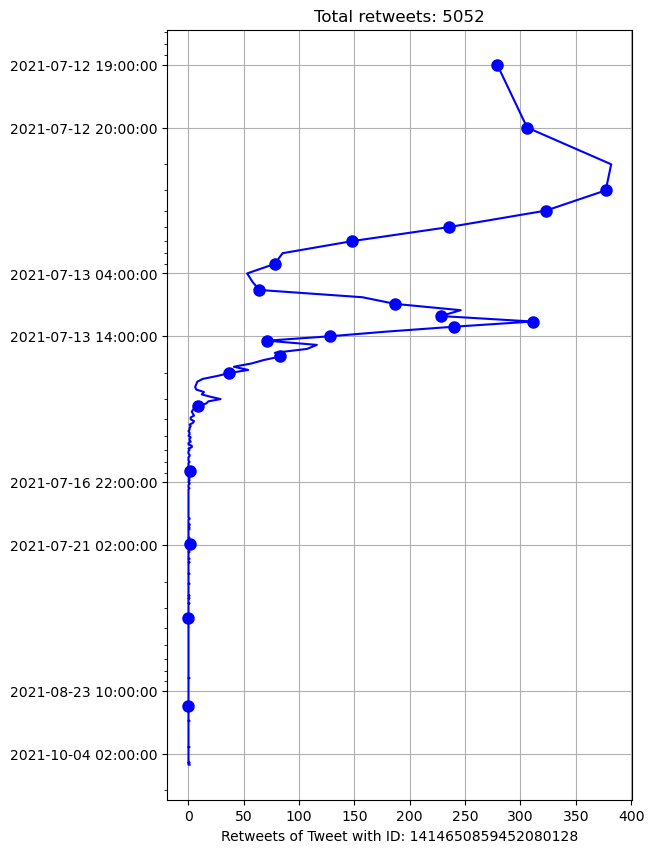

In [17]:
plot_reshares_freq(ddf, '1414650859452080128', color='blue', marker='o')

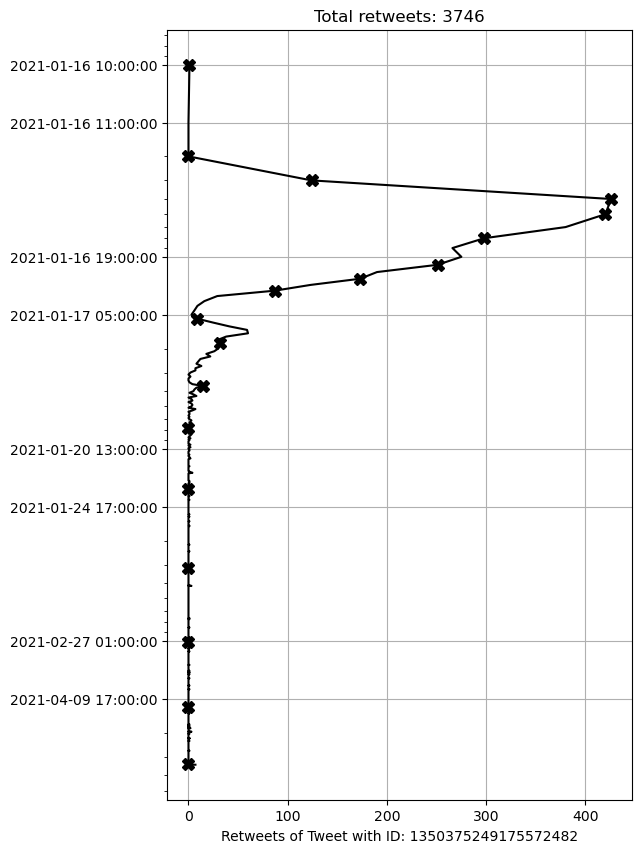

In [18]:
plot_reshares_freq(ddf, '1350375249175572482', color='black', marker='X')

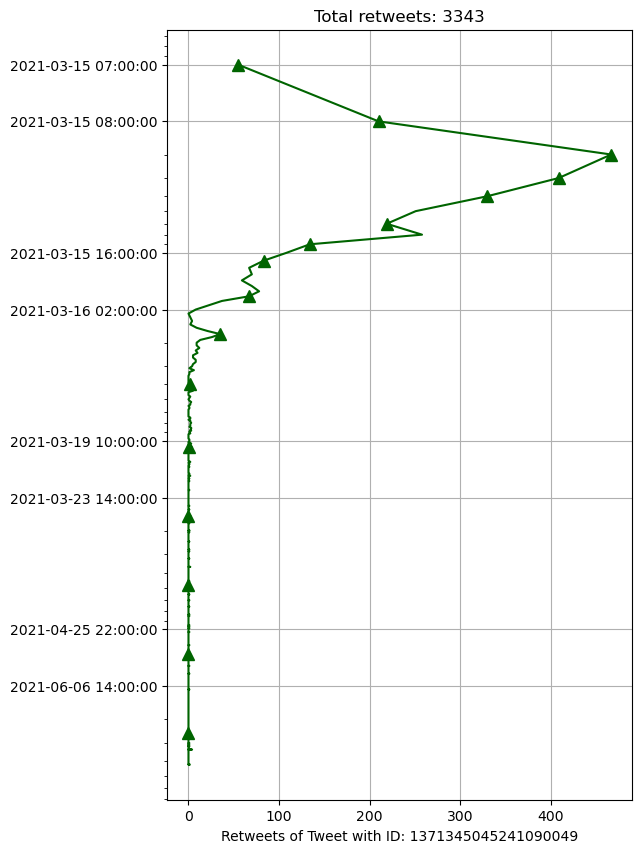

In [19]:
plot_reshares_freq(ddf, '1371345045241090049', color='darkgreen', marker='^')

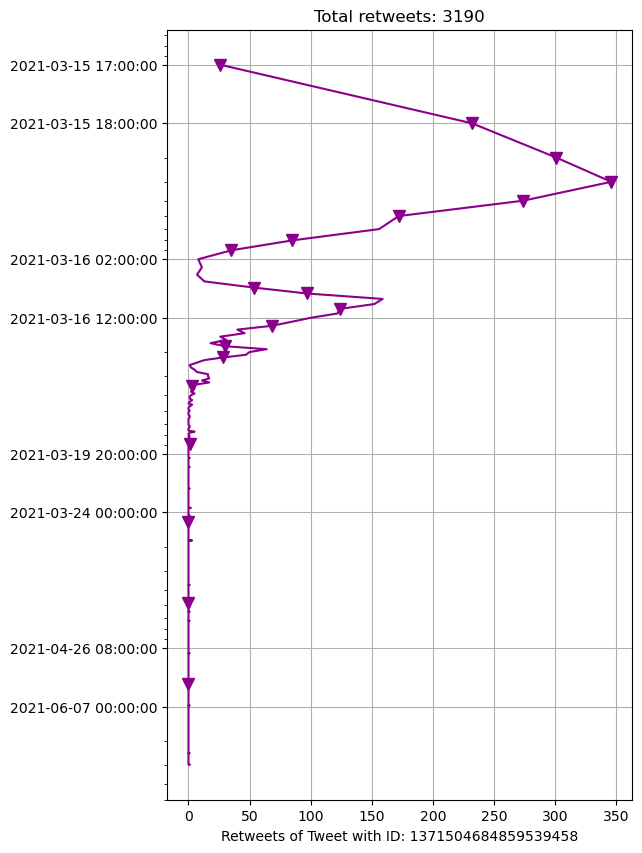

In [20]:
plot_reshares_freq(ddf, '1371504684859539458', color='darkmagenta', marker='v')